In [1]:
import nltk
import pandas as pd
import numpy as np
from processing import *
from sentiment import *

# PREPARASI *TRAINING DATASET*

In [7]:
# TODO: pindah ke sqlite
dataset = pd.read_csv("dataset/training_dataset.csv")
all_pos = dataset[dataset['label'] == 1]
all_neg = dataset[dataset['label'] == 0]


# * Training data: 80% pertama
# * Testing data: 20% terakhir
train_pos = all_pos.iloc[:int(len(all_pos)*0.8),:]
train_neg = all_neg.iloc[:int(len(all_neg)*0.8),:]
test_pos = all_pos.iloc[:int(len(all_pos)*0.2):]
test_neg = all_neg.iloc[:int(len(all_neg)*0.2):]

train_x = train_pos.append(train_neg, ignore_index=True)
test_x = test_pos.append(test_neg, ignore_index=True)

train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))
test_y = np.append(np.ones(len(test_pos)), np.zeros(len(test_neg)))

In [11]:
ld = len(dataset)
trp = len(train_pos)
tng = len(train_neg)
tsp = len(test_pos)
tsn = len(test_neg)
print(f"dataset: {ld} \n train pos: {trp} \n train neg: {tng} \n test pos: {tsp} \n test neg: {tsn}")

dataset: 1300 
 train pos: 511 
 train neg: 528 
 test pos: 127 
 test neg: 132


# PELATIHAN *MODEL CLASSIFIER*

In [12]:
x = train_x['text']
y = train_y
kamus_frek = kamus_freq(x, y)

In [13]:
logprior, loglikelihood = train_nbc(kamus_frek, train_x, train_y)

## HASIL PENGUJIAN MODEL
- data *training*
- data *testing*

In [14]:
hasil_uji = test_nbc(x, y, logprior, loglikelihood)
hasil_uji

0.9749759384023099

In [33]:
test = test_nbc(test_x['text'], test_y, logprior, loglikelihood)
test

0.9845559845559846

## UJI KESELURUHAN *DATASET*

In [ ]:
data_test = test_nbc(dataset['text'], dataset['label'], logprior, loglikelihood)
data_test

## *CONFUSION MATRIX*

In [59]:
pdc = pd.DataFrame()
pdc = dataset
pdc['label_prediksi'] = pdc['text'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

In [60]:
def toLabel(x):
    if x > 0:
        return 1
    elif x < 0:
        return 0
    else:
        return "n"
pdc['prediksi'] = pdc['label_prediksi'].apply(lambda x: toLabel(x))

In [61]:
pdc

,text,label,label_prediksi,prediksi
0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,0,-28.469450,0
1,Geblek lo tata...cowo bgt dibela2in balikan......,0,-6.972478,0
2,Kmrn termewek2 skr lengket lg duhhh kok labil ...,0,-10.987958,0
3,"Intinya kalau kesel dengan ATT nya, gausah ke ...",0,-27.500376,0
4,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",0,-11.574943,0
...,...,...,...,...
1295,Fargo juga adaptasi dari film yang cukup berha...,1,-0.014899,0
1296,637.000 waw ini sangat keren flm horor dng jum...,1,3.765355,1
1297,@filmziarah film yang tenang dan menghanyutkan...,1,-0.278355,0
1298,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,3.855516,1


In [65]:
conf_matrix = pd.crosstab(pdc['label'], pdc['prediksi'], rownames=['Actual'], colnames=['Predicted'])
conf_matrix

Predicted,0,1
Actual,,
0,647,14
1,81,558


In [67]:
tp = 558
tn = 647
fp = 14
fn = 81
pop = tp+tn+fp+fn
acc = (tp+tn)/pop
mis = (fp+fn)/pop
pre = tp/(tp+fp)
sen = tp/(tp+fn)
print(f"akurasi: {acc}\nmis-klasifikasi: {mis}\npresisi: {pre}\nsensitivitas: {sen}")

akurasi: 0.926923076923077
mis-klasifikasi: 0.07307692307692308
presisi: 0.9755244755244755
sensitivitas: 0.8732394366197183


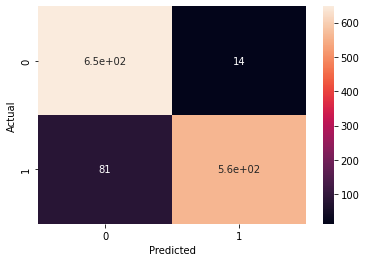

In [66]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(conf_matrix, annot=True)
plt.show()

# UJI CLASSIFIER PADA ARTIKEL BERITA

In [23]:
berita = open('berita.txt', 'r')
berita = berita.read()

## SENTIMEN ARTIKEL KESELURUHAN

In [32]:
predict_nbc(berita, logprior, loglikelihood)

-33.3003778808566

## SENTIMEN ARTIKEL PER_KALIMAT

In [28]:
from nltk.tokenize import sent_tokenize
x = pd.DataFrame()
kalimat = sent_tokenize(berita)
x['kalimat'] = kalimat
x['kalimat_normal'] = x['kalimat'].apply(lambda x: normalisasi(x))

In [30]:
x['label_prediksi'] = x['kalimat'].apply(lambda x: predict_nbc(x, logprior, loglikelihood))

## SENTIMEN ARTIKEL PER_KATA

In [43]:
berita_normal = normalisasi(berita)

In [46]:
# * predict_nbc per-kata
def predict_perkata(text, logpri, loglik):
    l = []
    for w in text:
        x = predict_nbc(w, logpri, loglik)
        l.append({
            w,
            x
            })
    return l

In [47]:
predict_perkata(berita_normal, logprior, loglikelihood)

[{-0.03272669350255697, 'beijing'},
 {-0.03272669350255697, 'kompas'},
 {-0.03272669350255697, 'china'},
 {-0.03272669350255697, 'selasa'},
 {0.6587042394965325, 'tari'},
 {-0.03272669350255697, 'utus'},
 {-0.03272669350255697, 'lithuania'},
 {-0.03272669350255697, 'beijing'},
 {-0.03272669350255697, 'vilnius'},
 {-0.03272669350255697, 'izin'},
 {-0.03272669350255697, 'taiwan'},
 {-0.03272669350255697, 'kantor'},
 {-1.826202410291468, 'negara'},
 {-0.5452685648294038, 'buah'},
 {0.6587042394965325, 'langkah'},
 {-0.03272669350255697, 'anggap'},
 {-0.7275901216233582, 'provokatif'},
 {-0.7275901216233582, 'perintah'},
 {-0.03272669350255697, 'china'},
 {-0.03272669350255697, 'taiwan'},
 {-0.03272669350255697, 'juli'},
 {-0.03272669350255697, 'kantor'},
 {-0.7275901216233582, 'wakil'},
 {-0.03272669350255697, 'vilnius'},
 {-0.7275901216233583, 'kota'},
 {-0.03272669350255697, 'lithuania'},
 {-0.5452685648294038, 'buah'},
 {0.6587042394965325, 'langkah'},
 {-0.03272669350255697, 'anggap'}